In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.losses import Loss
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, RandomFlip, RandomRotation
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt

In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


X_train = X_train / 255.0
X_test = X_test / 255.0

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(type(X_train))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
<class 'numpy.ndarray'>


In [ ]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))

    data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1)
    ])

    model.add(data_augmentation)
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", strides=(1, 1), activation='relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size =(2, 2), strides = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding="same", strides=(1, 1), activation='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding="same", strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size =(2, 2), strides = (2, 2)))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding="same", strides=(1, 1), activation='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding="same", strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size =(2, 2), strides = (2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=None, num_classes=None):
        super().__init__()
        self.gamma = gamma
        if num_classes is None:
            raise ValueError("The 'num_classes' parameter must be specified.")
        if alpha is None:
            alpha = [1 for _ in range(num_classes)]
        elif len(alpha) != num_classes:
            raise ValueError("The length of 'alpha' must be equal to 'num_classes'.")
        self.alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)

    def call(self, y_true, y_pred):
        if y_true.shape != y_pred.shape:
            raise ValueError(f"Invalid shape: y_true {y_true.shape} != y_pred {y_pred.shape}")
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.clip_by_value(y_pred, clip_value_min= 1e-6, clip_value_max=1-1e-6)

        entropy = -tf.math.log(y_pred) * y_true

        weight = tf.math.pow(1.0 - y_pred, self.gamma)
        loss = self.alpha * weight * entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))


Testing focal loss with alpha = 1 for every class and gamma = 0. This setup should give the same results as categorical crossentropy.

In [ ]:
a = np.array([[0.1, 0.1, 0.6, 0.1, 0.1], [0.1, 0.55, 0.15, 0.1, 0.1]])
a = tf.clip_by_value(a, clip_value_min= 1e-6, clip_value_max=1-1e-6)
a = tf.cast(a, dtype=tf.float32)

b = np.array([[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0]])
b = tf.cast(b, dtype=tf.float32)

cce = tf.keras.losses.CategoricalCrossentropy()
print("Expected value:", cce(b, a).numpy(), "\n")

# Step by step values
# gamma = 0.0
# alpha = 1.0

# entropy = -b * tf.math.log(a)
# weight = tf.math.pow(1.0 - a, gamma)
# loss = alpha * weight * entropy

# print("CE:", entropy.numpy())
# print("\nWeight:", weight)
# print("\nLoss", loss)

# print("\nFocal loss:", tf.reduce_mean(tf.reduce_sum(loss, axis=1)))

loss = FocalLoss(gamma=0, num_classes=5)
print("Focal loss:", loss.call(b, a).numpy())

Expected value: 0.5543313 

Focal loss: 0.5543313


In [ ]:
one_hot_ytrain = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
one_hot_ytest = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')
print(one_hot_ytrain.shape)
print(one_hot_ytest.shape)
one_hot_ytrain

(50000, 10)
(10000, 10)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Function used to calculate the alpha values for each class.

In [ ]:
def calculate_weigths(y):
    counts = np.unique(y, return_counts=True)[1]
    weights = 1 / (counts / len(y))
    sum_weights = np.sum(weights)
    return weights / sum_weights

# https://www.kaggle.com/datasets/nih-chest-xrays/sample
counts = np.array([13, 62, 84, 118, 127, 141, 176, 226, 271, 284, 313, 508, 644, 967, 3044])
len_y = np.sum(counts)
weights = 1 / (counts / len_y)
sum_weights = np.sum(weights)
print(weights / sum_weights)
print(sum(weights / sum_weights))



[0.50016874 0.10487409 0.07740707 0.05510334 0.05119838 0.04611485
 0.03694428 0.02877077 0.02399333 0.02289505 0.02077378 0.01279959
 0.01009657 0.00672409 0.00213607]
1.0000000000000002


In [ ]:
weights = calculate_weigths(y_train)
model = create_model()
model.compile(optimizer='adam', loss=FocalLoss(gamma=2.0, alpha=weights, num_classes=10), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [ ]:
history = model.fit(X_train, one_hot_ytrain, epochs=20, batch_size=32, validation_data=(X_test, one_hot_ytest))
test_loss, test_acc = model.evaluate(X_test, one_hot_ytest, verbose=2)
print('Test accuracy:', test_acc)

Epoch 1/20
1563/1563 [==============================] - 25s 8ms/step - loss: 0.1165 - accuracy: 0.3850 - val_loss: 0.0867 - val_accuracy: 0.5163
Epoch 2/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0817 - accuracy: 0.5344 - val_loss: 0.0655 - val_accuracy: 0.6136
Epoch 3/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0690 - accuracy: 0.6005 - val_loss: 0.0626 - val_accuracy: 0.6319
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0616 - accuracy: 0.6332 - val_loss: 0.0598 - val_accuracy: 0.6537
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0574 - accuracy: 0.6550 - val_loss: 0.0543 - val_accuracy: 0.6856
Epoch 6/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0544 - accuracy: 0.6716 - val_loss: 0.0525 - val_accuracy: 0.6987
Epoch 7/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0515 - accuracy: 0.6849 - val_loss: 0.0497 - val_ac

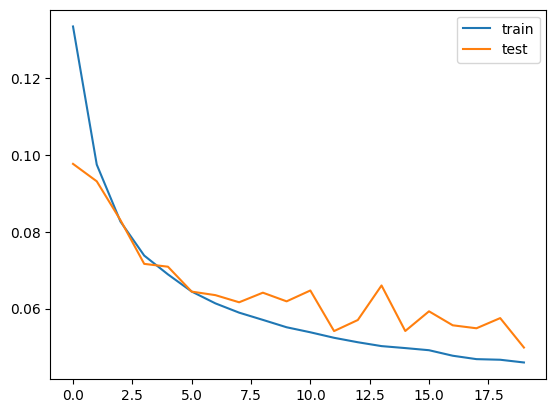

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()